!pip install keras
!pip install sklearn
!pip install livelossplot

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import livelossplot
import pickle

In [92]:
plot_losses = livelossplot.PlotLossesKeras()
Files_Folder = 'Dados/'
path = Files_Folder + 'DataBase.xlsx'
dados = pd.read_excel(path)
dados = dados.sort_values("Dia", ascending=True)

# Define critério de limpeza da variável de controle
primeiroQuartil = np.percentile(dados["PRINCIPAL (kW)"].values, 25)
terceiroQuartil = np.percentile(dados["PRINCIPAL (kW)"].values, 75)
passo = 1.5 * (terceiroQuartil - primeiroQuartil)

df = []
for i in range(0, len(dados)):
    consumo = dados["PRINCIPAL (kW)"].values[i]
    if consumo > primeiroQuartil - passo and consumo < terceiroQuartil + passo:
        df.append(dados.values[i])
        
dados = pd.DataFrame(df, columns=dados.columns)

In [93]:
# Faz a limpeza das variáveis de entrada
entrada = dados.drop(columns=["PRINCIPAL (kW)", "Dia"]).values
remove = IsolationForest(random_state=0).fit(entrada)
out = remove.predict(entrada)

df = []
for i in range(0, len(out)):
    if out[i] == 1:
        df.append(dados.values[i])
        
dados = pd.DataFrame(df, columns=dados.columns)

'''# Insere a informação de sazonalidade
sazon = []
for i in range(0, len(dados)):
    ts = pd.Timestamp(dados["Dia"].values[i])
    sazon.append(ts.month)

dados["Sazonalidade"] = sazon'''

In [94]:
# Separa o dataframe de teste e de treino
volumeTreino = 0.9
iCorte = int(len(dados) * volumeTreino)
dfTreino = dados.loc[:iCorte, :]
dfTeste = dados.loc[iCorte:, :]

# Separa variáveis dependentes e independentes
xTreino = dfTreino.drop(columns=["PRINCIPAL (kW)", "Dia"]).values
yTreino = dfTreino["PRINCIPAL (kW)"].values

xTeste = dfTeste.drop(columns=["PRINCIPAL (kW)", "Dia"]).values
yTeste = dfTeste["PRINCIPAL (kW)"].values

# Executa a padronização
sc = StandardScaler()
xTreino = sc.fit_transform(xTreino)
xTeste = sc.transform(xTeste)

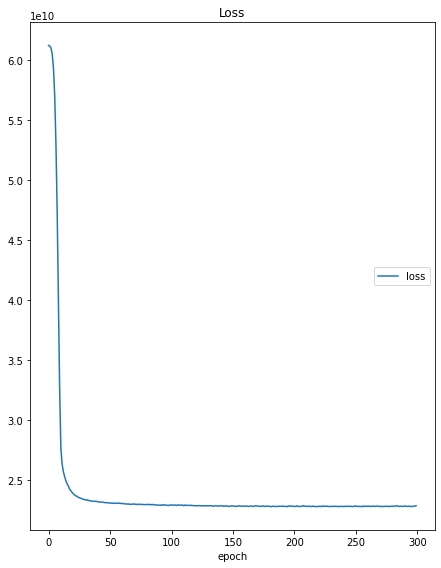

Loss
	loss             	 (min: 22762301440.000, max: 61202071552.000, cur: 22847463424.000)


In [95]:
# Cria a rede neural
ann = Sequential()
ann.add(Dense(10, activation="relu"))
ann.add(Dense(50, activation="relu"))
ann.add(Dense(100, activation="relu"))
ann.add(Dense(50, activation="relu"))
ann.add(Dense(10, activation="relu"))
ann.add(Dense(1, activation="linear"))
    
# Compila e treina
ann.compile(optimizer="RMSprop", loss="mean_squared_error")
hist = ann.fit(xTreino, yTreino, batch_size=32, epochs=300, verbose=0,callbacks=[plot_losses])
#finalLoss = hist.history["loss"][-1]

In [96]:
finalLoss = hist.history["loss"][-1]

In [97]:
# Faz a predição para o conjunto de teste
yPred = ann.predict(xTeste).reshape(1, -1)[0]
residuos = []
for i in range(0, len(yPred)):
    if yTeste[i] == 0:
        continue
        
    residuos.append((abs(yPred[i] - yTeste[i]) / yTeste[i]))

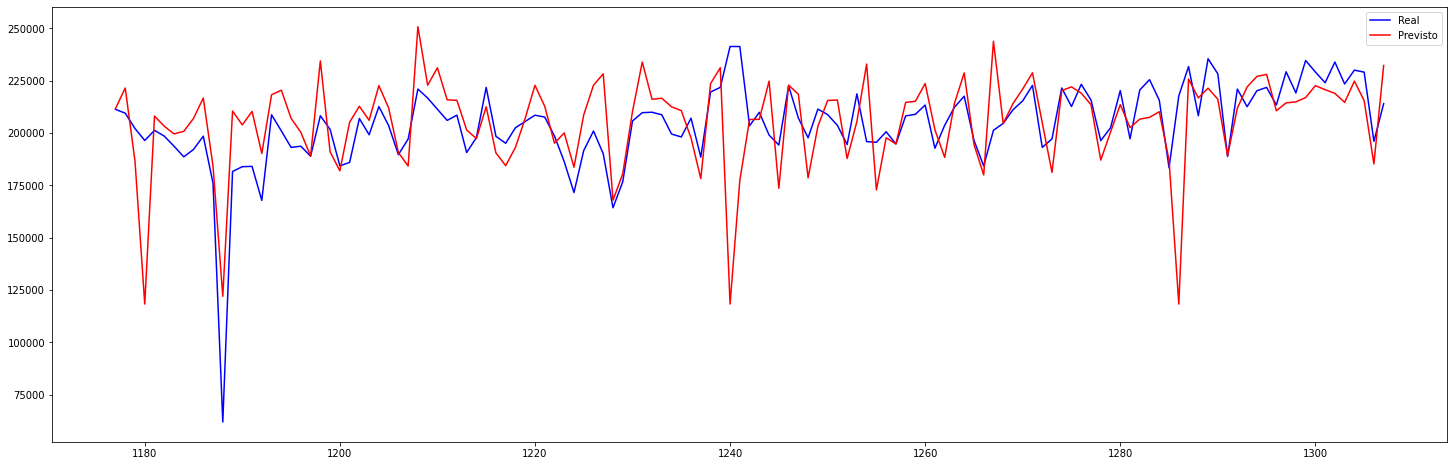

In [98]:
# Cria as listas para visualização
plotTreino = np.array([i for i in range(0, len(yTreino))])
plotTeste = np.array([i for i in range(len(yTreino), len(yTreino) + len(yTeste))])

plt.figure(figsize=(25, 8))
#plt.plot(plotTreino, yTreino, label="Treino", color="black")
plt.plot(plotTeste, yTeste, label="Real", color="blue")
plt.plot(plotTeste, yPred, label="Previsto", color="red")
plt.legend()
plt.show()

Código para importar dados que queremos usar para fazer predições e salvar um arquivo com as predições realizadas

In [99]:
path_pred = 'Dados/DadosPredicao.xlsx'
dados_pred = pd.read_excel(path_pred)
dados_pred = dados_pred.sort_values("Dia", ascending=True)

xPred = dados_pred.drop(columns=["PRINCIPAL (kW)", "Dia"]).values

# Executa a padronização
xPred = sc.transform(xPred)

Prediz os valores e salva o arquivo

In [100]:
yPred = ann.predict(xPred).reshape(1, -1)[0]
dados_pred['Prediction'] = yPred
dados_pred.to_excel(Files_Folder + 'Output.xlsx', index = False)

# save the model to disk
filename = Files_folder + 'finalized_model.sav'
pickle.dump(ann, open(filename, 'wb'))